In [ ]:
import os
import subprocess
pdb_path = 'wet_exp/Gn-Ab1C5-coot-19.pdb' # the path to the pdb file
design_contig = '7-11' # '' for designing all CDRH3. the residue indices in the HCDR3 to be designed, i.e., the 7th to 11th residues in the HCDR3, include both ends.
heavy_chain_id = 'B' # the id of the heavy chain in the pdb file

outdir = 'wet_exp/dock_single'
seq_design_dir = 'wet_exp/seq_design'
screen_dir = 'wet_exp/screen'
num_gpus = 2
process_per_gpu = 10

pdb_name = os.path.basename(pdb_path).split('.')[0]
docked_pose_dir = f"{outdir}/dock_cdr/{pdb_name}_/H_CDR3/"
summary_path = f"{outdir}/dock_cdr/{pdb_name}_/summary.csv"


In [9]:
import numpy as np
import pandas as pd
import glob
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json
import glob
!pip install logomaker


def summarize_seqs(design_dir):
    
    records = []
    for path in glob.glob(design_dir+'/*_rosetta.pdb_/aa.csv'):
        pdb_id = path.split('/')[-2]
        df = pd.read_csv(path)
        # append df to out_df
        # out_df = out_df.append(df)

        aar = df['AAR'].mean()
        ppl = df['PPL'].mean()
        aa = df['sampled_aa'].iloc[0]
        records.append({'pdb_id': pdb_id, 'AAR': aar, 'PPL': ppl, 'AA':aa})
    out_df = pd.DataFrame(records)
    out_df.to_csv(design_dir+'/summary.csv', index=False)
    return out_df

def plot_logo(aas):
    import logomaker
    # create a Logo object
    counts_mat = logomaker.alignment_to_matrix(aas)
    logomaker.Logo(counts_mat)
    return counts_mat



In [ ]:
# Generate docking poses
subprocess.run(['python', 'dock_pdb.py', '--pdb_path', pdb_path, '--config', 'configs/test/dock_cdr.yml', '--ckpt', 'reproduction/dock_single_cdr/250000.pt', '-n', '1000', '-b', '1000', '-d', 'cuda', '-o', outdir])
subprocess.run(['python', 'optimize_ab.py', '--num_gpus', num_gpus, '--process_per_gpu', process_per_gpu, '--docked_pose_dir', docked_pose_dir, '--seq_design_dir', seq_design_dir, '--design_contig', design_contig, '--screen_dir', screen_dir, '--heavy_chain_id', heavy_chain_id])


In [11]:
seq_design_out_dir = os.path.join('wet_exp/seq_design', 'seq_design')
seq_design_df = summarize_seqs(seq_design_out_dir)
seq_design_df.sort_values(by='AAR', ascending=True).head()
seq_design_df['id'] = seq_design_df['pdb_id'].apply(lambda x: x.split('_')[0])

print(seq_design_df.head())
print(seq_design_df.shape)

              pdb_id    AAR       PPL     AA    id
0  0005_rosetta.pdb_  0.226  0.125157  YYCNC  0005
1  0002_rosetta.pdb_  0.230  0.125151  YYWNS  0002
2  0016_rosetta.pdb_  0.020  0.125155  IYSVS  0016
3  0006_rosetta.pdb_  0.004  0.125156  RLSYS  0006
4  0008_rosetta.pdb_  0.008  0.125154  WSIYI  0008
(430, 5)


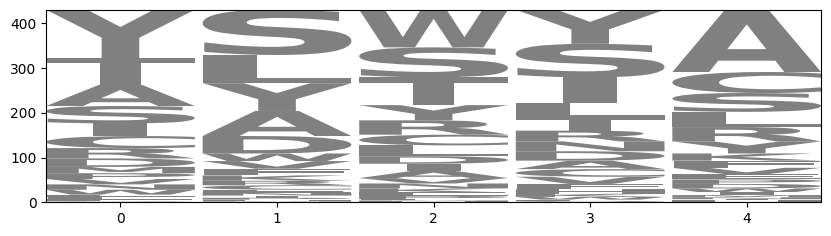

In [12]:
# mutation_position = [103,104,105, 106]
design_aa_counts = plot_logo(seq_design_df['AA'])

In [20]:
screen_out_dir = os.path.join(screen_dir, 'dock_cdr')

records = []
for result_path,seq_path in zip(
    glob.glob(f'{screen_out_dir}/*/results.csv'),
    glob.glob(f'{screen_out_dir}/*/aa.csv')
):
    pdb_id = result_path.split('/')[-2]
    df = pd.read_csv(result_path)
    seq_df = pd.read_csv(seq_path)
    aa = seq_df['sampled_aa'].iloc[0]
    dockq_list = eval(df['DockQ'].iloc[0])
    prmsd_list = eval(df['prmsd'].iloc[0])
    records.append({
        'id': pdb_id.split('_')[0],
        'aa': aa,
        'DockQ_avg': np.mean(dockq_list),
        'prmsd_avg': np.mean(prmsd_list),
        'DockQ_std': np.std(dockq_list),
        'prmsd_std': np.std(prmsd_list),
    })
screening_df = pd.DataFrame(records)

screening_df.head()

,id,aa,DockQ_avg,prmsd_avg,DockQ_std,prmsd_std
0,0006,DRWEVDRLSYSGTYHRNMGDY,0.26529,1.696933,0.144497,0.233316
1,0016,DRWEVDIYSVSGTYHRNMGDY,0.16897,1.644612,0.104249,0.123364
2,0005,DRWEVDYYCNCGTYHRNMGDY,0.18686,1.394828,0.068693,0.041361
3,0015,DRWEVDYKTNRGTYHRNMGDY,0.22583,1.493542,0.117774,0.068492
4,0021,DRWEVDYSWTAGTYHRNMGDY,0.14879,1.526475,0.068936,0.098622


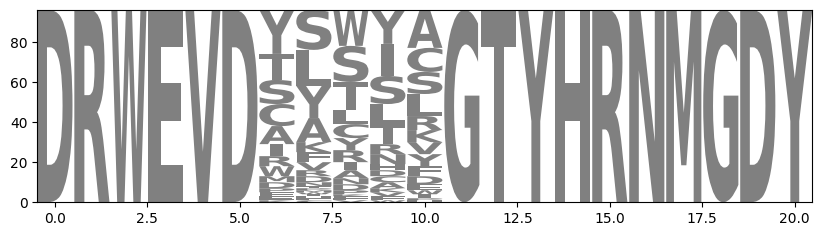

In [21]:
aa_counts = plot_logo(screening_df['aa'])

In [27]:
quantiles = screening_df.quantile([0.75, 0.5,  0.25],numeric_only=True)

# Filter out top 30% of samples in DockQ_std and prmsd_std
filtered_df = screening_df[(screening_df['DockQ_std'] <= quantiles.loc[0.5, 'DockQ_std']) &
                        (screening_df['prmsd_std'] <= quantiles.loc[0.5, 'prmsd_std'])&
                        # (screening_df['DockQ_avg'] >= quantiles.loc[0.5, 'DockQ_avg'])&
                        (screening_df['prmsd_avg'] <= quantiles.loc[0.5, 'prmsd_avg'])
                        ]
print(filtered_df.shape)

(18, 6)


In [28]:
filtered_df

,id,aa,DockQ_avg,prmsd_avg,DockQ_std,prmsd_std
2,0005,DRWEVDYYCNCGTYHRNMGDY,0.18686,1.394828,0.068693,0.041361
3,0015,DRWEVDYKTNRGTYHRNMGDY,0.22583,1.493542,0.117774,0.068492
4,0021,DRWEVDYSWTAGTYHRNMGDY,0.14879,1.526475,0.068936,0.098622
6,0012,DRWEVDTFCSCGTYHRNMGDY,0.20582,1.586058,0.086129,0.063987
7,0067,DRWEVDDDRHCGTYHRNMGDY,0.16726,1.499442,0.055111,0.041985
13,0139,DRWEVDDKWCCGTYHRNMGDY,0.35361,1.467219,0.111506,0.068139
17,0187,DRWEVDSSLFDGTYHRNMGDY,0.14338,1.475256,0.061153,0.092634
18,0191,DRWEVDSLNLCGTYHRNMGDY,0.30620,1.533012,0.106017,0.055653
26,0271,DRWEVDYVSCFGTYHRNMGDY,0.25667,1.412440,0.084938,0.066843
28,0289,DRWEVDCSCIRGTYHRNMGDY,0.17300,1.332596,0.047645,0.041230


In [37]:
filtered_df.to_csv('mutation_five_points.csv', index=False,float_format='%.3f')

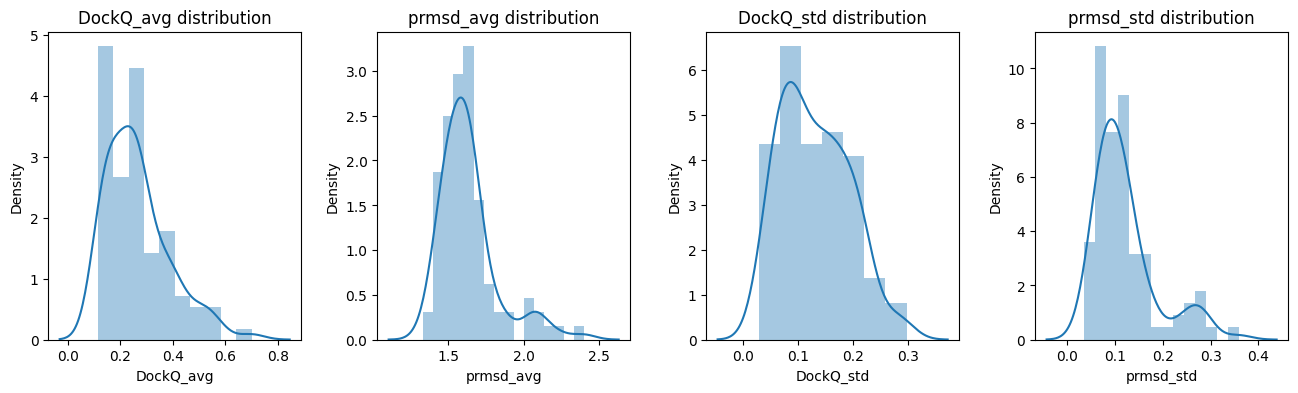

In [36]:
# create a grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))

# plot the distributions of each column in a separate subplot
sns.distplot(screening_df['DockQ_avg'], ax=axes[ 0])
sns.distplot(screening_df['prmsd_avg'], ax=axes[1])
sns.distplot(screening_df['DockQ_std'], ax=axes[2])
sns.distplot(screening_df['prmsd_std'], ax=axes[3])

# set the titles and labels of each subplot
axes[0].set(title='DockQ_avg distribution', xlabel='DockQ_avg')
axes[1].set(title='prmsd_avg distribution', xlabel='prmsd_avg')
axes[2].set(title='DockQ_std distribution', xlabel='DockQ_std')
axes[3].set(title='prmsd_std distribution', xlabel='prmsd_std')

# adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.show()